In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5149442%2F8605812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240604%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240604T171232Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1515c7eb4cf8f0782f439f9682b618d2e5ad01de0e306c1411e083c4d41331ac9c92dd10c492289451509436180cc7d6d6e99e8167cb8c57cb1e9f67081f74665661a49a652caccbe3139346c5df62523b1628555f7dffaf86e0c8eda1896543a4076bbd8d082e35b7102dbe1e0d61ccb6f0db25af61197bda520e36e3d7f35ad88b68b709a044f0026e0cf8d9480774ba24c09b3a26ba4b75fae937715f9d2f3909e9b3c8a7668ee68f6129d03fd0c0f5ee324dd5549a362ffebb8305672f766bd2ee70f4e2f9ed7c56c7b71c01ba965b202c74c695039f5cd5fce408730ae82d375f0a5d5cb552f1636ebc3cf531bea717b3e64631d1503b31baf37e1b2301'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 114207324 bytes downloaded
Downloaded and uncompressed: dataset
Data source import complete.


In [29]:
!pip install keras_preprocessing keras_visualizer

In [35]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, MaxPooling1D, Flatten, SpatialDropout1D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras_visualizer import visualizer
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [4]:
# some constants
MAX_WORDS = 8000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 300
BATCH_SIZE = 128
NUM_EPOCHS = 8
VALIDATION_SPLIT = 0.2

# seeding
np.random.seed(42)

In [5]:
def get_data_labels(path):
    data = []
    labels = []
    for label in ['pos', 'neg']:
        dir_name = os.path.join(path, label)
        for fname in os.listdir(dir_name):
            if fname.endswith('.txt'):
                with open(os.path.join(dir_name, fname), 'r', encoding='utf-8') as f:
                    data.append(f.read())
                labels.append(1 if label == 'pos' else 0)
    return data, labels

In [6]:
train_data, train_labels = get_data_labels('/kaggle/input/dataset/train')
test_data, test_labels = get_data_labels('/kaggle/input/dataset/test')

In [7]:
# merge train and test data
data = train_data + test_data
labels = train_labels + test_labels

train_df = pd.DataFrame({'data': data, 'label': labels})
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [8]:
train_df.to_csv("movie_reviews.csv",index=False)

In [9]:
train_df = pd.read_csv('movie_reviews.csv')
train_df.head(5)

,data,label
0,"Based on Mika Waltari's Book,This Second Cinem...",1
1,Winchester 73 gets credit from many critics fo...,1
2,<br /><br />An old man works as a janitor in a...,1
3,"Difficult film to comment on, how do you say i...",1
4,Ok let's start with saying that when a dutch m...,0


In [10]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]*>', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

train_df['data'] = train_df['data'].apply(preprocess_text)
train_df.head(5)

,data,label
0,based on mika waltaris bookthis second cinemas...,1
1,winchester 73 gets credit from many critics fo...,1
2,an old man works as a janitor in a mental hos...,1
3,difficult film to comment on how do you say it...,1
4,ok lets start with saying that when a dutch mo...,0


In [11]:
# split data
X_train, X_test, y_train, y_test = train_test_split(train_df['data'], train_df['label'], test_size=0.3, random_state=42)

In [12]:
# tokenize data
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [13]:
# pad sequences
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

In [16]:
vocab = len(tokenizer.word_index)+1

In [17]:
def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_index = load_glove_embeddings('glove.6B.100d.txt')

In [18]:
def create_embedding_matrix(embeddings_index, word_index, max_words, embedding_dim):
    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = create_embedding_matrix(embeddings_index, tokenizer.word_index, vocab, 100)

In [33]:
# build model
model = Sequential()
model.add(Embedding(vocab, 100, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False))
model.add(Conv1D(256, 3, padding="same", activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, padding="same", activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(250,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 100)          13691300  
                                                                 
 conv1d_5 (Conv1D)           (None, 500, 256)          77056     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 250, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 250, 128)          98432     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 125, 128)          0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 16000)            

In [36]:
visualizer(model,file_name="cnn_graph", file_format="png", view=True)

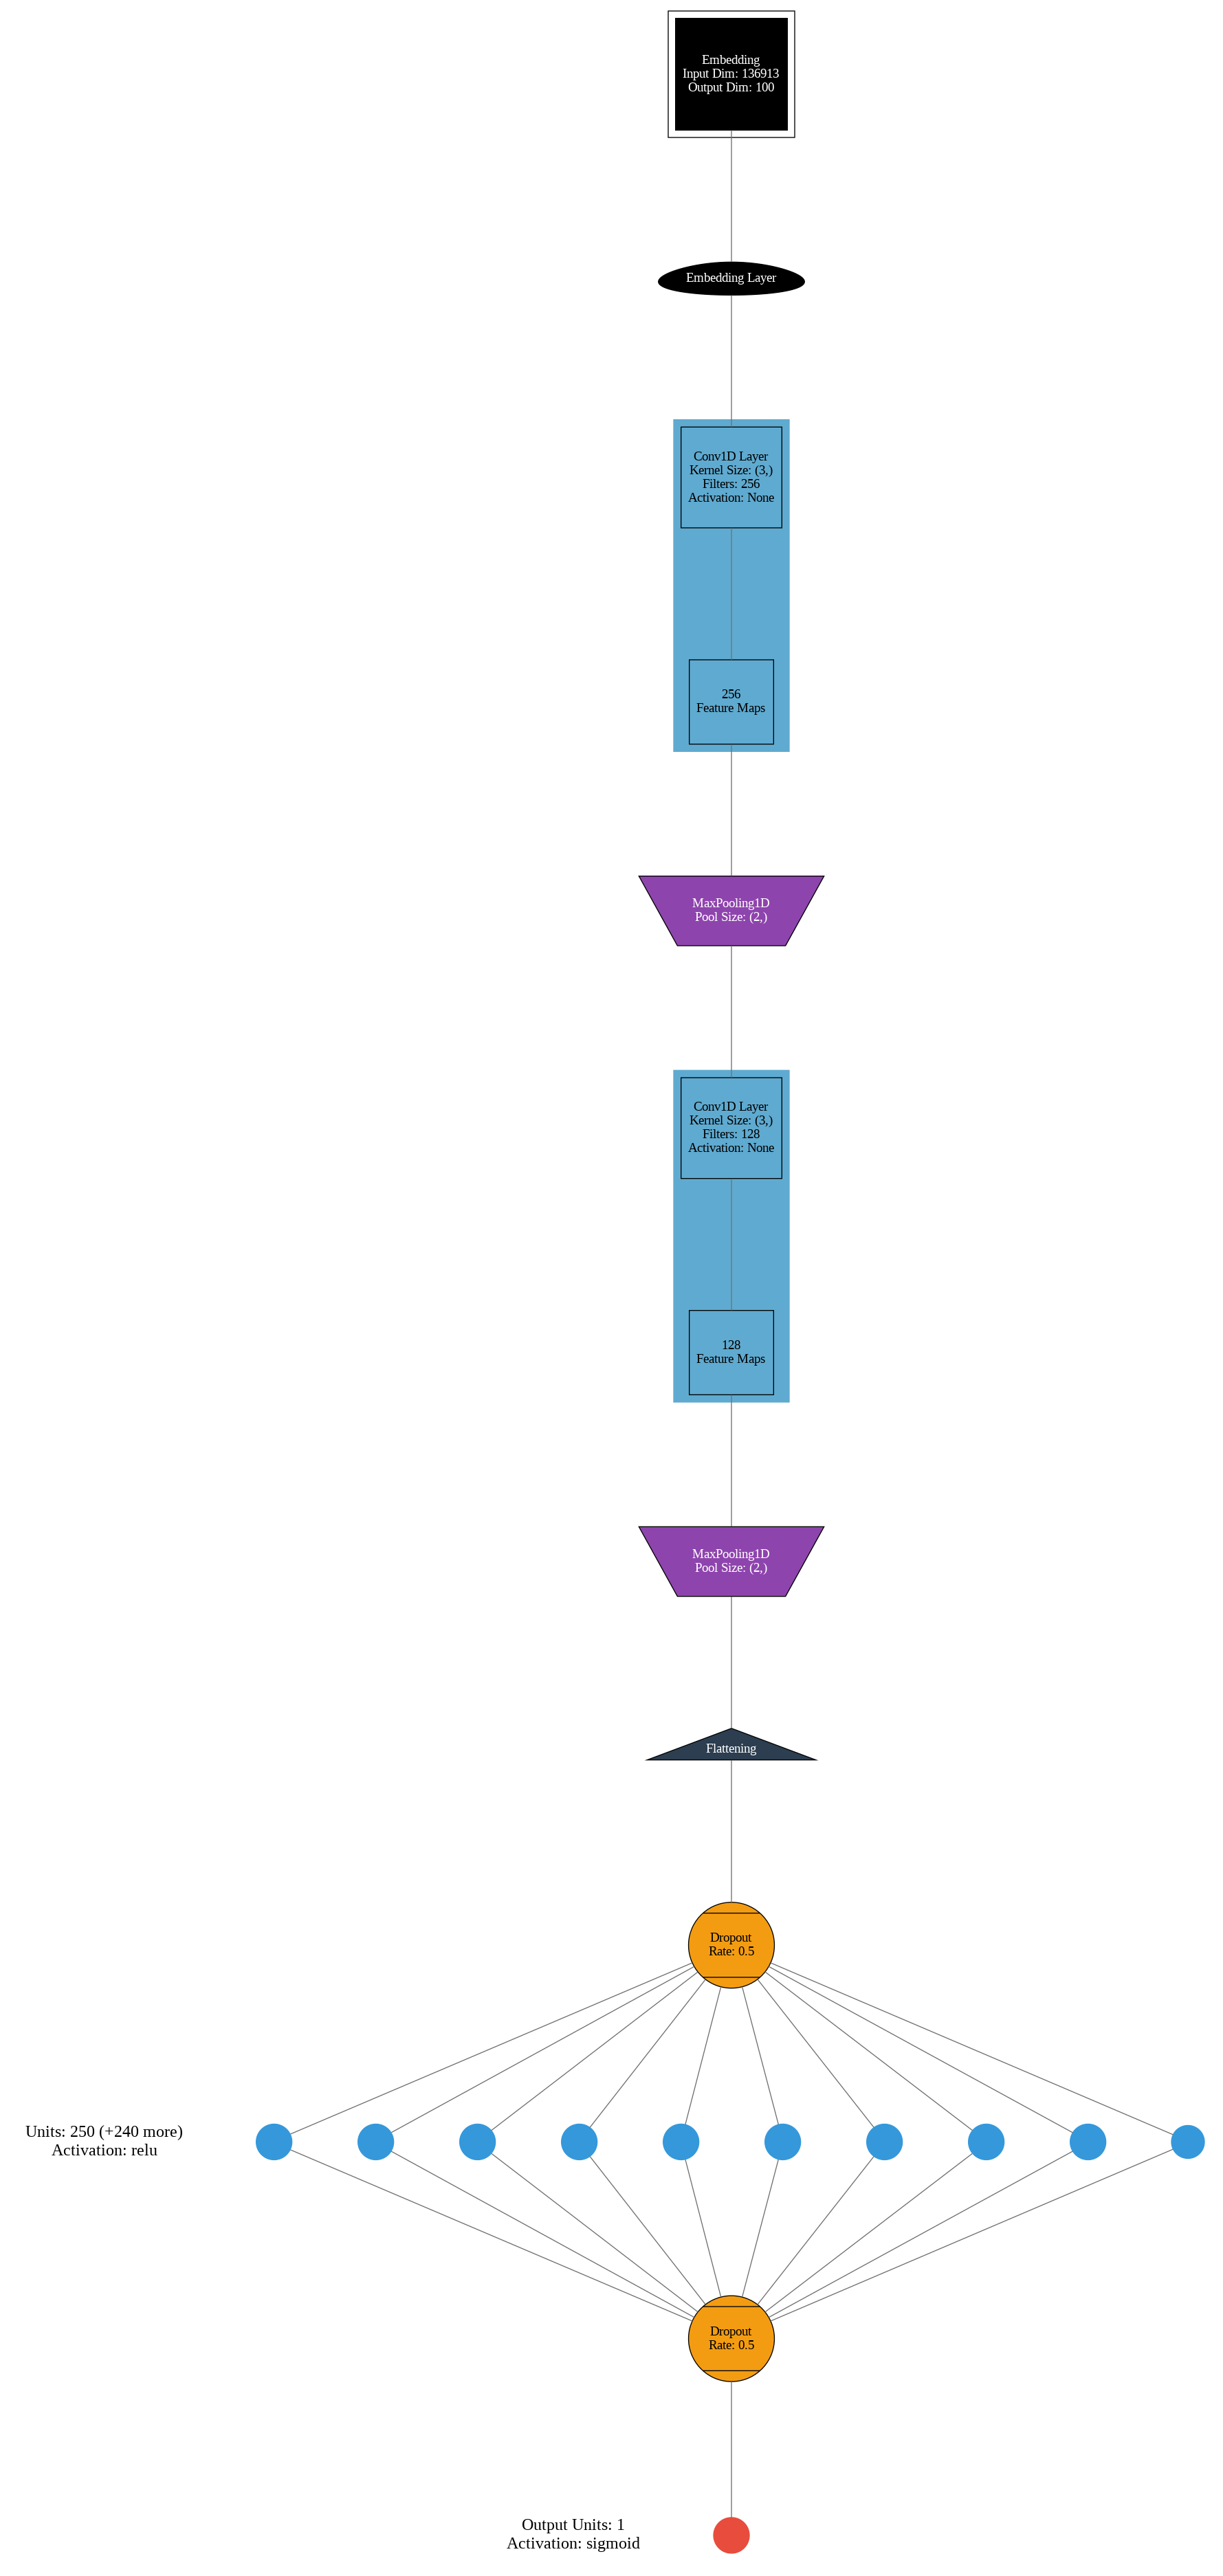

In [40]:
im = Image.open("cnn_graph.png")
display(im)

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train model with early stopping
cnn = model.fit(X_train, np.array(y_train), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/8
219/219 [==============================] - 13s 32ms/step - loss: 0.6248 - accuracy: 0.6298 - val_loss: 0.4884 - val_accuracy: 0.7534
Epoch 2/8
219/219 [==============================] - 5s 25ms/step - loss: 0.4459 - accuracy: 0.7937 - val_loss: 0.3486 - val_accuracy: 0.8456
Epoch 3/8
219/219 [==============================] - 6s 26ms/step - loss: 0.3772 - accuracy: 0.8325 - val_loss: 0.3279 - val_accuracy: 0.8619
Epoch 4/8
219/219 [==============================] - 6s 26ms/step - loss: 0.3300 - accuracy: 0.8591 - val_loss: 0.3081 - val_accuracy: 0.8704
Epoch 5/8
219/219 [==============================] - 6s 26ms/step - loss: 0.3047 - accuracy: 0.8713 - val_loss: 0.3529 - val_accuracy: 0.8529
Epoch 6/8
219/219 [==============================] - 6s 27ms/step - loss: 0.2726 - accuracy: 0.8861 - val_loss: 0.2996 - val_accuracy: 0.8757
Epoch 7/8
219/219 [==============================] - 6s 26ms/step - loss: 0.2490 - accuracy: 0.8961 - val_loss: 0.3030 - val_accuracy: 0.8719
Epoch

In [ ]:
# evaluate model
loss, accuracy = model.evaluate(X_test, np.array(y_test))
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


469/469 [==============================] - 2s 4ms/step - loss: 0.3017 - accuracy: 0.8801
Test loss: 0.30168819427490234
Test accuracy: 0.8800666928291321


In [ ]:
# Evaluation metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_test)
predictions = [1 if x > 0.5 else 0 for x in predictions]

print('Classification Report:')
print(classification_report(y_test, predictions))

print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions))


469/469 [==============================] - 2s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      7470
           1       0.86      0.90      0.88      7530

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000

Confusion Matrix:
[[6388 1082]
 [ 717 6813]]


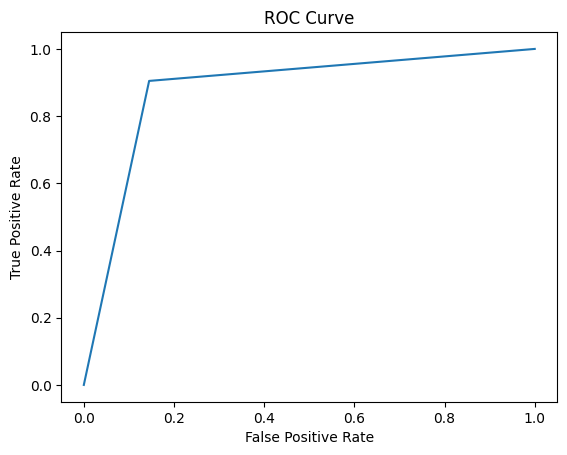

In [ ]:
# calculate roc curve and auc
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


In [ ]:
# precision, recall, f1 score specificity, accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.metrics import specificity_score

precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
specificity = specificity_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Specificity: {specificity}')
print(f'Accuracy: {accuracy}')

Precision: 0.8629512349588347
Recall: 0.904780876494024
F1 Score: 0.8833711507293356
Specificity: 0.8551539491298528
Accuracy: 0.8800666666666667


In [ ]:
# save model
model.save('cnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### LSTM

In [ ]:
train_df = pd.read_csv('movie_reviews.csv')

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]*>', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

train_df['data'] = train_df['data'].apply(preprocess_text)
train_df.head(5)

,data,label
0,based on mika waltaris bookthis second cinemas...,1
1,winchester 73 gets credit from many critics fo...,1
2,an old man works as a janitor in a mental hos...,1
3,difficult film to comment on how do you say it...,1
4,ok lets start with saying that when a dutch mo...,0


In [ ]:
# split data
X_train, X_test, y_train, y_test = train_test_split(train_df['data'], train_df['label'], test_size=0.3, random_state=42)

In [ ]:
# tokenize data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# pad sequences
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
vocab = len(tokenizer.word_index)+1

In [ ]:
#lstm = Sequential()
#lstm.add(Embedding(vocab, 100, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False))
#lstm.add(LSTM(200))
#lstm.add(Dense(1, activation='sigmoid'))
#lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#lstm_model = model.fit(X_train, np.array(y_train), validation_split=0.2, epochs=5, batch_size=128, verbose=1)

Epoch 1/5
219/219 [==============================] - 6s 29ms/step - loss: 0.0223 - accuracy: 0.9928 - val_loss: 0.7626 - val_accuracy: 0.8767
Epoch 2/5
219/219 [==============================] - 6s 29ms/step - loss: 0.0214 - accuracy: 0.9926 - val_loss: 0.6931 - val_accuracy: 0.8769
Epoch 3/5
219/219 [==============================] - 6s 27ms/step - loss: 0.0215 - accuracy: 0.9927 - val_loss: 0.7494 - val_accuracy: 0.8767
Epoch 4/5
219/219 [==============================] - 6s 28ms/step - loss: 0.0292 - accuracy: 0.9900 - val_loss: 0.6939 - val_accuracy: 0.8654
Epoch 5/5
219/219 [==============================] - 6s 28ms/step - loss: 0.0219 - accuracy: 0.9928 - val_loss: 0.6444 - val_accuracy: 0.8791


In [ ]:
#lstm.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 500, 100)          13691300  
                                                                 
 lstm_15 (LSTM)              (None, 200)               240800    
                                                                 
 dense_20 (Dense)            (None, 128)               25728     
                                                                 
 dense_21 (Dense)            (None, 1)                 129       
                                                                 
Total params: 13957957 (53.25 MB)
Trainable params: 266657 (1.02 MB)
Non-trainable params: 13691300 (52.23 MB)
_________________________________________________________________


In [ ]:
#lstm_result = lstm.evaluate(X_test,np.array(y_test))
#print("Test Accuracy:", lstm_result[1])
#print("Test Loss:", lstm_result[0])

469/469 [==============================] - 5s 11ms/step - loss: 0.6996 - accuracy: 0.4981
Test Accuracy: 0.4981333315372467
Test Loss: 0.6996094584465027


In [41]:
lstm = Sequential()
lstm.add(Embedding(vocab, 100, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False))
lstm.add(SpatialDropout1D(0.2))
lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
visualizer(lstm,file_name="lstm_graph", file_format="png", view=True)

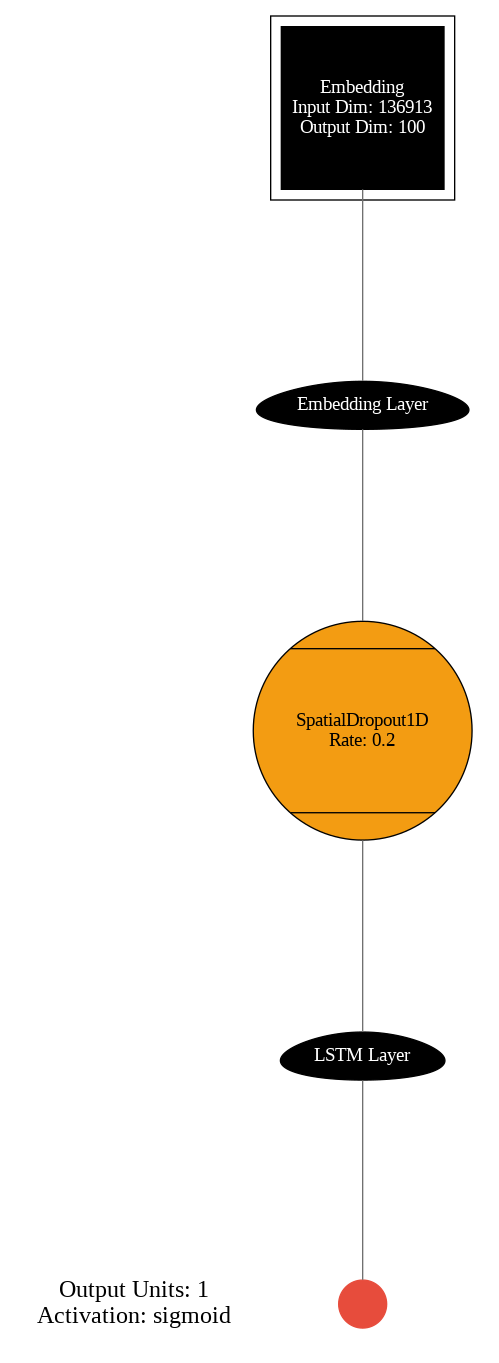

In [50]:
lstm_img = Image.open("lstm_graph.png")
display(lstm_img)

In [ ]:
lstm_model = model.fit(X_train, np.array(y_train), validation_split=0.2, epochs=5, batch_size=128, verbose=1)

Epoch 1/5
219/219 [==============================] - 350s 2s/step - loss: 0.5682 - accuracy: 0.6967 - val_loss: 0.4288 - val_accuracy: 0.8107
Epoch 2/5
219/219 [==============================] - 328s 2s/step - loss: 0.3901 - accuracy: 0.8274 - val_loss: 0.3408 - val_accuracy: 0.8610
Epoch 3/5
219/219 [==============================] - 329s 2s/step - loss: 0.3310 - accuracy: 0.8578 - val_loss: 0.2878 - val_accuracy: 0.8831
Epoch 4/5
219/219 [==============================] - 331s 2s/step - loss: 0.3007 - accuracy: 0.8717 - val_loss: 0.2957 - val_accuracy: 0.8784
Epoch 5/5
219/219 [==============================] - 327s 1s/step - loss: 0.2630 - accuracy: 0.8930 - val_loss: 0.2678 - val_accuracy: 0.8936


In [ ]:
lstm_result = lstm.evaluate(X_test,np.array(y_test))
print("Test Accuracy:", lstm_result[1])
print("Test Loss:", lstm_result[0])

469/469 [==============================] - 84s 177ms/step - loss: 0.7354 - accuracy: 0.5021
Test Accuracy: 0.5020666718482971
Test Loss: 0.7354270219802856


In [ ]:
# Evaluation metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predictions = lstm.predict(X_test)
predictions = [1 if x > 0.5 else 0 for x in predictions]

print('Classification Report:')
print(classification_report(y_test, predictions))

print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions))

469/469 [==============================] - 5s 10ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.03      0.06      7470
           1       0.50      0.97      0.66      7530

    accuracy                           0.50     15000
   macro avg       0.50      0.50      0.36     15000
weighted avg       0.50      0.50      0.36     15000

Confusion Matrix:
[[ 246 7224]
 [ 249 7281]]


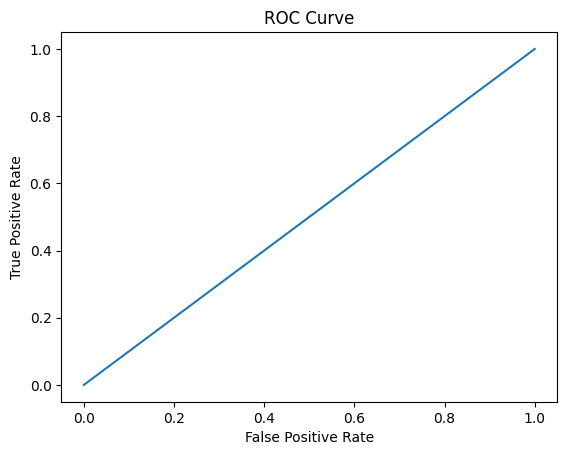

In [ ]:
# calculate roc curve and auc
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


### LSTM AND CNN

In [19]:
model_conv = Sequential()
model_conv.add(Embedding(vocab, 100,input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False))
model_conv.add(LSTM(100,return_sequences=True))
model_conv.add(Conv1D(64, 3, padding='same',activation='relu'))
model_conv.add(MaxPooling1D(pool_size=2))
model_conv.add(Flatten())
model_conv.add(Dropout(0.8))
model_conv.add(Dense(250, activation='relu'))
model_conv.add(Dropout(0.8))
model_conv.add(Dense(1, activation='sigmoid'))
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
visualizer(model_conv,file_name="lstm_cnn_graph", file_format="png", view=True)

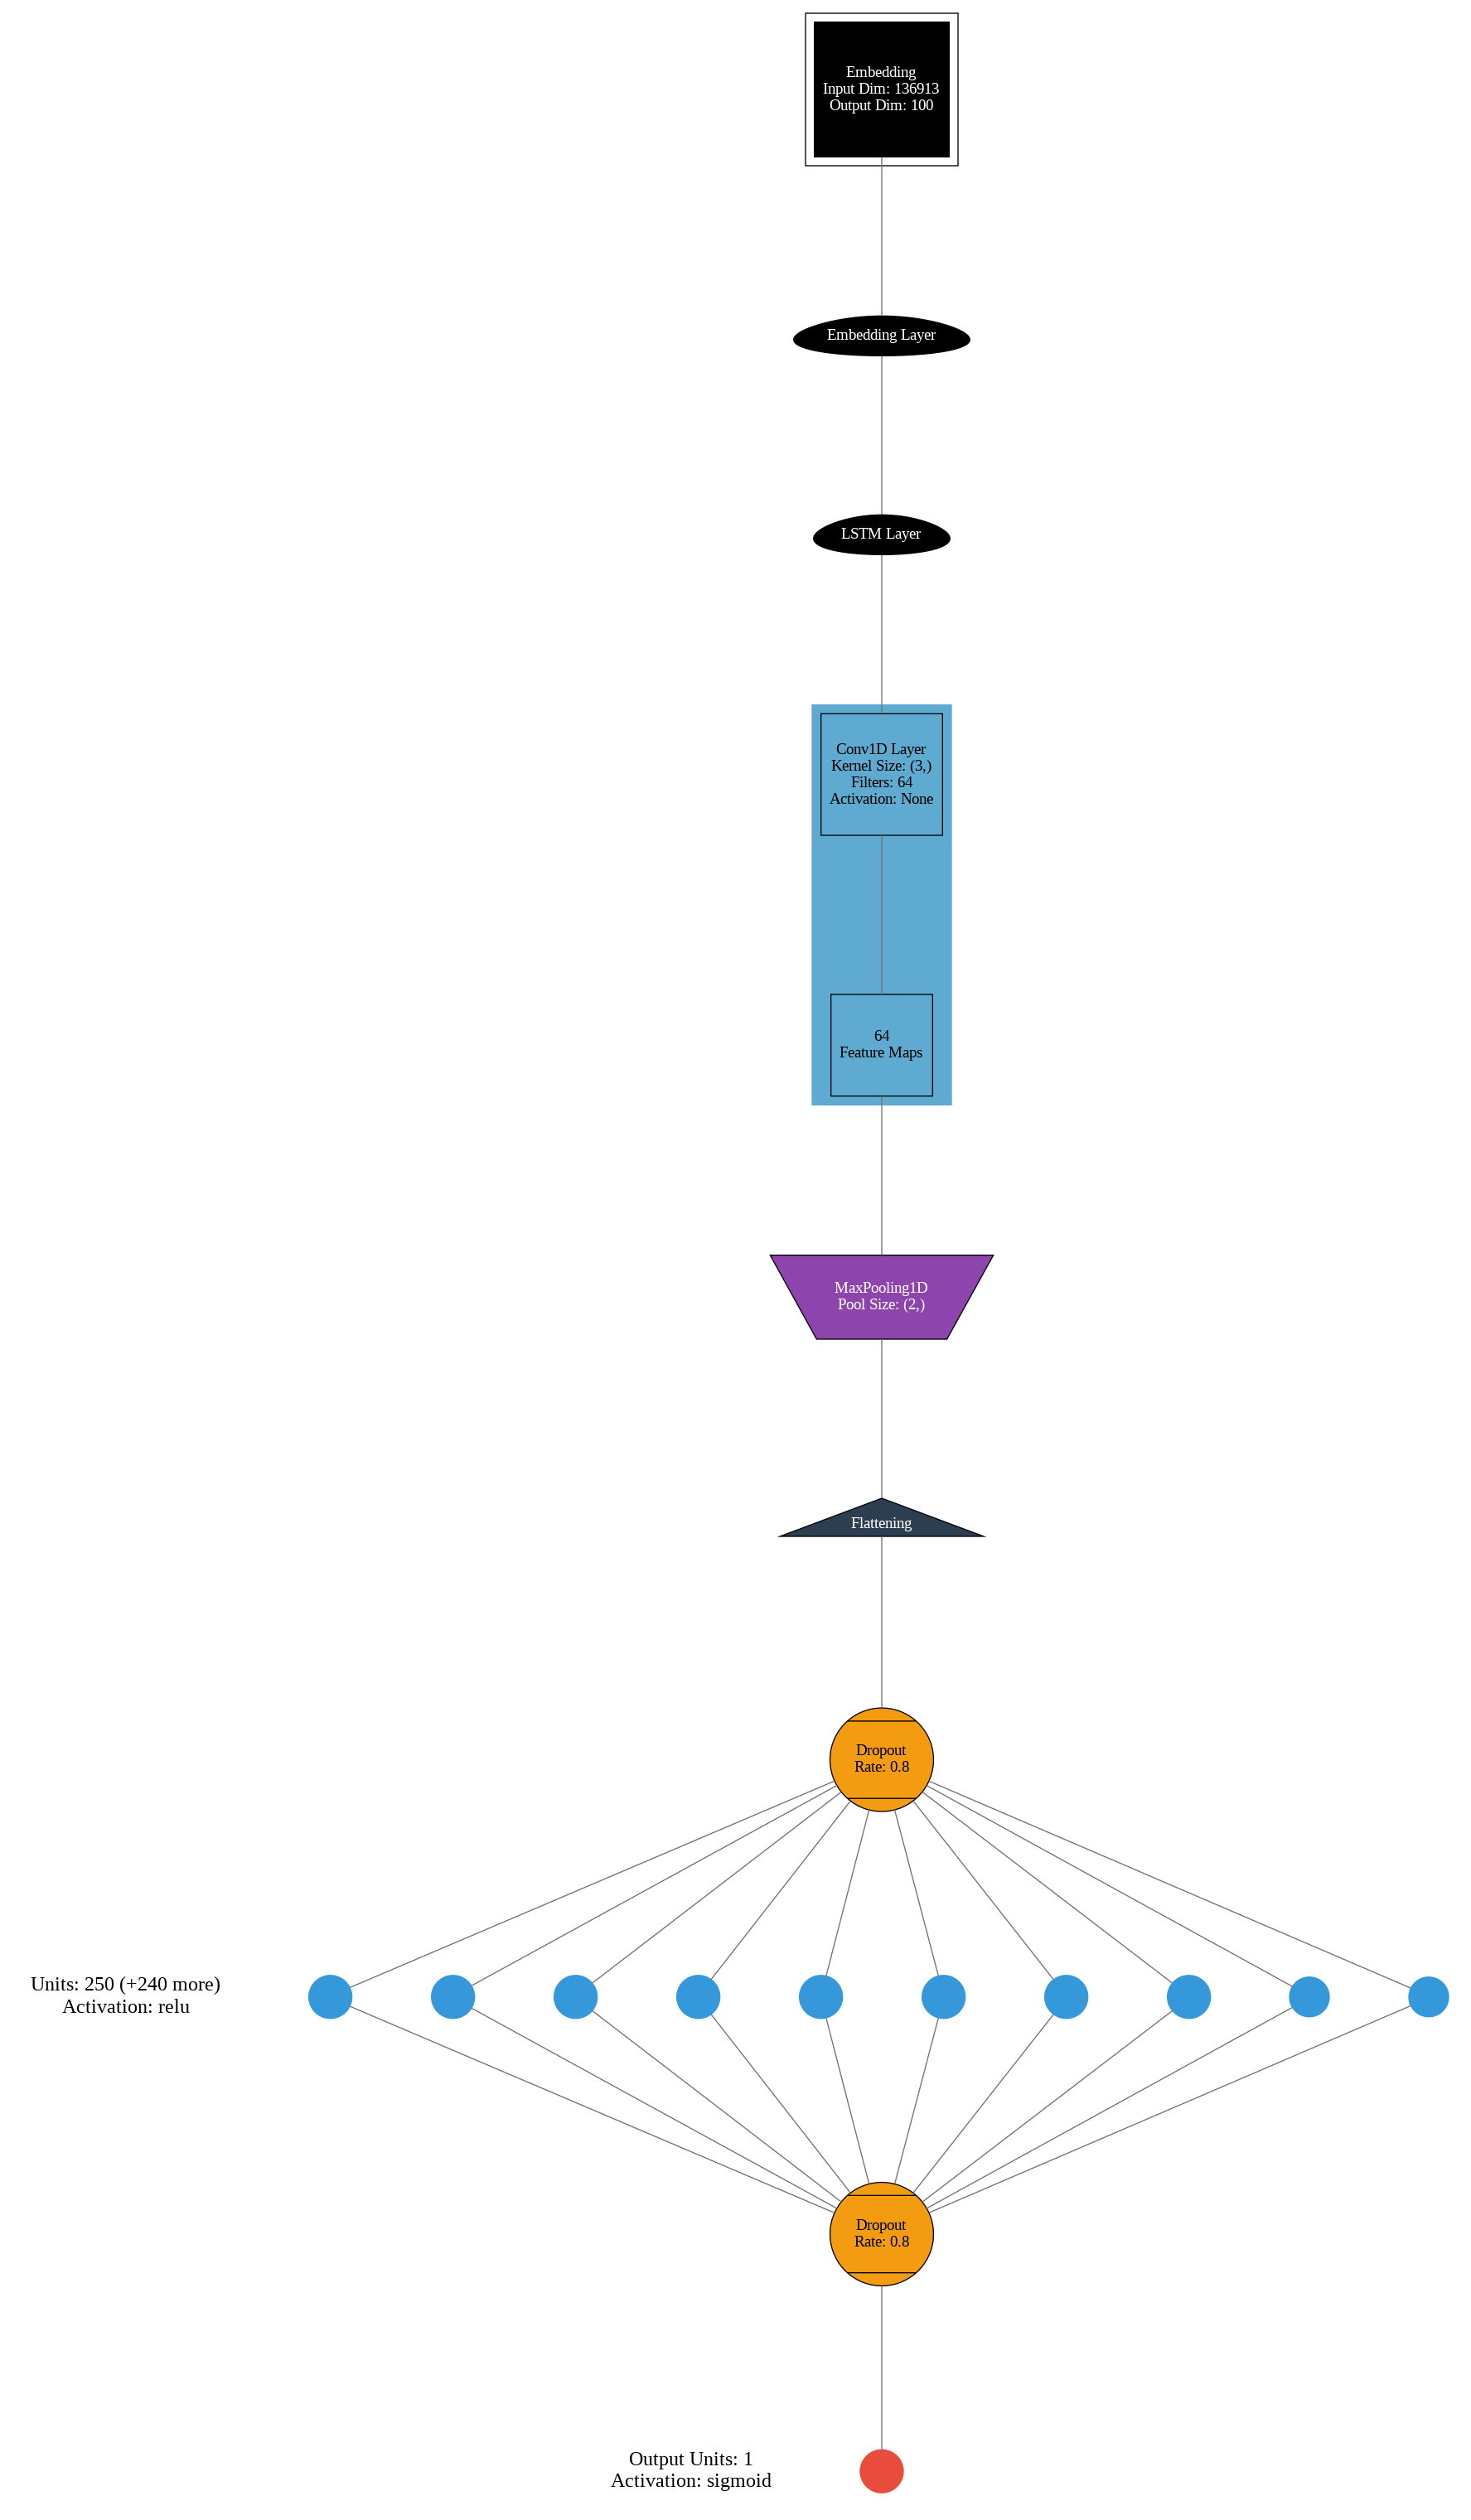

In [52]:
lstm_cnn_img = Image.open("lstm_cnn_graph.png")
display(lstm_cnn_img)

In [20]:
model_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          13691300  
                                                                 
 lstm (LSTM)                 (None, 500, 100)          80400     
                                                                 
 conv1d (Conv1D)             (None, 500, 64)           19264     
                                                                 
 max_pooling1d (MaxPooling1  (None, 250, 64)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dropout (Dropout)           (None, 16000)             0         
                                                        

In [21]:
model_conv.fit(X_train, y_train, validation_split=0.2, epochs=6, batch_size=128, verbose=2)

Epoch 1/6
219/219 - 17s - loss: 0.5830 - accuracy: 0.6829 - val_loss: 0.4205 - val_accuracy: 0.8136 - 17s/epoch - 77ms/step
Epoch 2/6
219/219 - 8s - loss: 0.4248 - accuracy: 0.8119 - val_loss: 0.3645 - val_accuracy: 0.8397 - 8s/epoch - 36ms/step
Epoch 3/6
219/219 - 8s - loss: 0.3664 - accuracy: 0.8435 - val_loss: 0.3185 - val_accuracy: 0.8591 - 8s/epoch - 35ms/step
Epoch 4/6
219/219 - 8s - loss: 0.3367 - accuracy: 0.8569 - val_loss: 0.3052 - val_accuracy: 0.8724 - 8s/epoch - 37ms/step
Epoch 5/6
219/219 - 8s - loss: 0.3151 - accuracy: 0.8677 - val_loss: 0.2983 - val_accuracy: 0.8751 - 8s/epoch - 37ms/step
Epoch 6/6
219/219 - 8s - loss: 0.3020 - accuracy: 0.8743 - val_loss: 0.3287 - val_accuracy: 0.8523 - 8s/epoch - 38ms/step


In [23]:
cnn_lstm_result = model_conv.evaluate(X_test,np.array(y_test))
print("Test Accuracy:", cnn_lstm_result[1])
print("Test Loss:", cnn_lstm_result[0])

469/469 [==============================] - 13s 18ms/step - loss: 0.3245 - accuracy: 0.8564
Test Accuracy: 0.8564320802688599
Test Loss: 0.3244984745979309


In [25]:
# Evaluation metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predictions = model_conv.predict(X_test)
predictions = [1 if x > 0.5 else 0 for x in predictions]

print('Classification Report:')
print(classification_report(y_test, predictions))

print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions))

469/469 [==============================] - 5s 10ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      7470
           1       0.80      0.95      0.87      7530

    accuracy                           0.86     15000
   macro avg       0.87      0.86      0.85     15000
weighted avg       0.87      0.86      0.85     15000

Confusion Matrix:
[[5665 1805]
 [ 349 7181]]


In [26]:
# precision, recall, f1 score specificity, accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.metrics import specificity_score

precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
specificity = specificity_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Specificity: {specificity}')
print(f'Accuracy: {accuracy}')

Precision: 0.7991319830847986
Recall: 0.9536520584329349
F1 Score: 0.869581012351659
Specificity: 0.7583668005354752
Accuracy: 0.8564


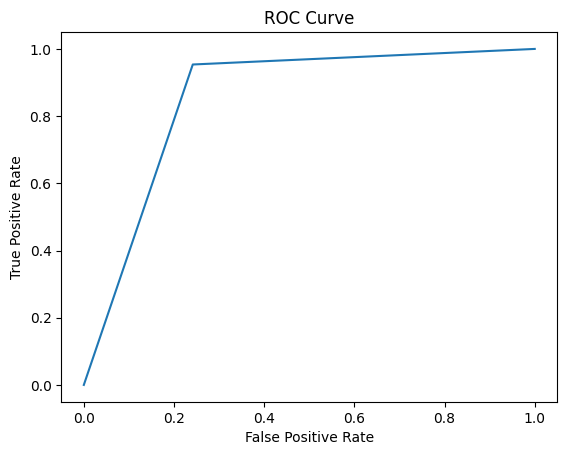

In [27]:
# calculate roc curve and auc
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
